# Univariate optimization with SciPy

Many engineering problems boil down to finding the minimum or maximum of a function of a single variable. This could be minimizing material usage, maximizing efficiency, or finding the optimal operating point of a system.

The `scipy.optimize` module in Python's SciPy library provides a powerful and user-friendly toolkit for these tasks. In this notebook, we will explore and compare three key methods for minimizing a single-variable function: `brent`, `bounded`, and `golden`. We will also uncover some of the powerful utility functions that give us finer control and deeper insight into the optimization process.

Let's begin by setting up our environment.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar, show_options, bracket

-----

## 1\. The Engineering Problem: Designing a Cylindrical Tank

To ground our exploration in a practical context, let's consider a classic engineering design problem. We need to design a cylindrical tank with a fixed volume $V$ of 500 m³. Our goal is to minimize the material used, which means minimizing the total surface area $A$.

The variables are the radius $r$ and height $h$ of the tank.

The volume is given by:
$$V = \pi r^2 h$$

The surface area (including the top and bottom lids) is:
$$A = 2\pi r^2 + 2\pi rh$$

Since the volume is fixed, we can express $h$ in terms of $r$:
$$h = \frac{V}{\pi r^2}$$

Substituting this into the area equation gives us a function of a single variable, $r$:
$$A(r) = 2\pi r^2 + 2\pi r \left( \frac{V}{\pi r^2} \right) = 2\pi r^2 + \frac{2V}{r}$$

This is the function we need to minimize. Let's define it in Python.

In [2]:
def surface_area(r, V=500):
  """
  Calculates the surface area of a cylindrical tank with a fixed volume.

  Args:
    r (float): The radius of the tank.
    V (float, optional): The fixed volume of the tank. Defaults to 500 m³.

  Returns:
    float: The total surface area of the tank.
  """
  Area = 2*np.pi*r**2 + 2*V/r

  # Return a large number for invalid radii
  if np.any(r <= 0):
    if isinstance(Area, np.ndarray):
      Area[r <= 0] = np.inf
    elif isinstance(Area, float):
      Area = np.inf

  return Area

Let's visualize the function to understand its behavior:

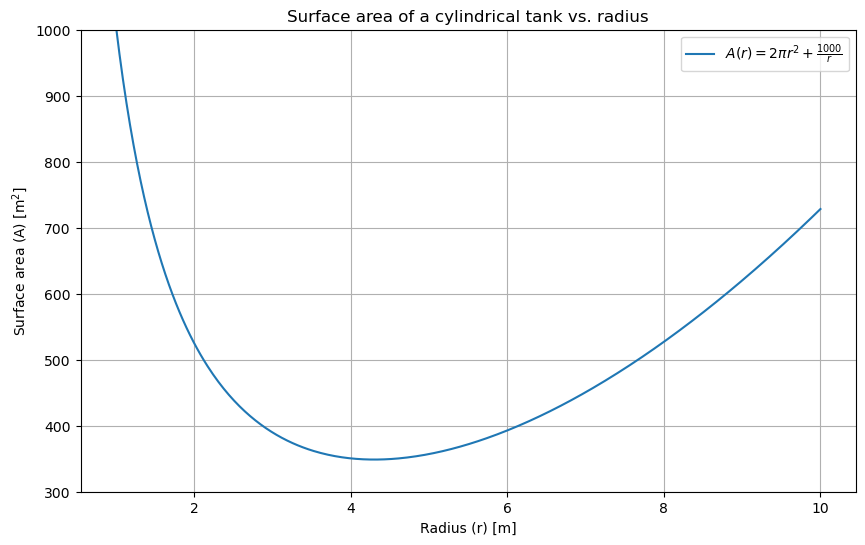

In [3]:
r_vals = np.linspace(1, 10, 400)
A_vals = surface_area(r_vals)

plt.figure(figsize=(10, 6))
plt.plot(r_vals, A_vals, label=r'$A(r) = 2\pi r^2 + \frac{1000}{r}$')
plt.xlabel("Radius (r) [m]")
plt.ylabel("Surface area (A) [m$^2$]")
plt.title("Surface area of a cylindrical tank vs. radius")
plt.legend()
plt.ylim(300, 1000)
plt.grid(True)
plt.show()

The plot clearly shows a single minimum, which we will now find using SciPy's optimization functions.

-----

## 2\. The `minimize_scalar` function

The workhorse for univariate optimization in SciPy is `minimize_scalar`. It takes a function and a chosen method as primary arguments to find the minimum.

### 2.1. Method 1: Brent's method (`method='brent'`)

Brent's method is often the default choice due to its robustness. It is a hybrid algorithm that combines the certainty of the golden-section search with the speed of parabolic interpolation:
  * **Parabolic Interpolation**: Fits a parabola through three points of the function and jumps to the parabola's minimum. This is very fast if the function behaves like a quadratic near the minimum.
  * **Golden-Section Search**: A slower but guaranteed method that narrows the search interval by a fixed ratio in each step. It doesn't require the function to be smooth.

Brent's method intelligently switches between these two strategies to provide both speed and convergence.

**Usage:**

To use Brent's method, you typically need to provide a **bracket**, which is a triplet of points $(a, b, c)$ such that $f(b) < f(a)$ and $f(b) < f(c)$, ensuring a minimum lies between $a$ and $c$. However, `minimize_scalar` can often find a bracket for you if you provide an interval `(a, c)`.

In [4]:
# Using minimize_scalar with Brent's method
# We provide a search interval, for instance, between a radius of 1 and 10.
brent_result = minimize_scalar(surface_area, bracket=(1, 10), method='brent')

print("Brent's Method Result:")
print(brent_result)

Brent's Method Result:
 message: 
          Optimization terminated successfully;
          The returned value satisfies the termination criteria
          (using xtol = 1.48e-08 )
 success: True
     fun: 348.734205452888
       x: 4.301270133158224
     nit: 16
    nfev: 19


The output is an `OptimizeResult` object, which we will discuss in detail later. For now, note the key attributes: `x` (the optimal radius) and `fun` (the minimum surface area).

### 2.2. Method 2: Golden-Section Search (`method='golden'`)

The golden-section search is a simple, robust, but often slower algorithm. Its strength is that it makes no assumptions about the function's smoothness (it doesn't use derivatives or parabolas). It works by narrowing the search interval by a constant factor related to the golden ratio, $\tau = \frac{\sqrt{5} - 1}{2} \approx 0.618$.

At each iteration, it evaluates the function at a new interior point and discards the portion of the interval that is known not to contain the minimum.

In [5]:
# Using minimize_scalar with the Golden-Section method
# This method also requires a bracket or search interval.
golden_result = minimize_scalar(surface_area, bracket=(1, 10), method='golden')

print("Golden-section method result:")
print(golden_result)

Golden-section method result:
 message: 
          Optimization terminated successfully;
          The returned value satisfies the termination criteria
          (using xtol = 1.4901161193847656e-08 )
 success: True
     fun: 348.7342054528879
       x: 4.3012700956548855
     nit: 40
    nfev: 45


You'll notice the result is very similar to Brent's method, but it might have taken more function evaluations (`nfev`).

### 2.3. Method 3: Bounded method (`method='bounded'`)

The `bounded` method is essentially Brent's method but with a mandatory, strict bounding interval. It guarantees that the search for the minimum will remain within the specified `bounds`. This is crucial in engineering problems where the variable has physical or practical constraints. For our tank, a negative radius is nonsensical, and perhaps there is an upper limit due to manufacturing constraints.

**Usage:**

In [6]:
# Using minimize_scalar with the Bounded method
# "bounds" is a mandatory argument for method='bounded'.
bounded_result = minimize_scalar(surface_area, bounds=(1, 10), method='bounded')

print("Bounded method result:")
print(bounded_result)

Bounded method result:
 message: Solution found.
 success: True
  status: 0
     fun: 348.734205452888
       x: 4.301270010083812
     nit: 12
    nfev: 12


### 2.4. Comparison of methods

Let's summarize the results and visualize them.

In [7]:
data = {
    'Method':                 ['Brent',          'Golden',            'Bounded'          ],
    'Optimal Radius (x)':     [brent_result.x,    golden_result.x,    bounded_result.x   ],
    'Min Surface Area (fun)': [brent_result.fun,  golden_result.fun,  bounded_result.fun ],
    'Iterations (nit)':       [brent_result.nit,  golden_result.nit,  bounded_result.nit ],
    'Func. Evals (nfev)':     [brent_result.nfev, golden_result.nfev, bounded_result.nfev]
}
df = pd.DataFrame(data)
df

,Method,Optimal Radius (x),Min Surface Area (fun),Iterations (nit),Func. Evals (nfev)
0,Brent,4.30127,348.734205,16,19
1,Golden,4.30127,348.734205,40,45
2,Bounded,4.30127,348.734205,12,12


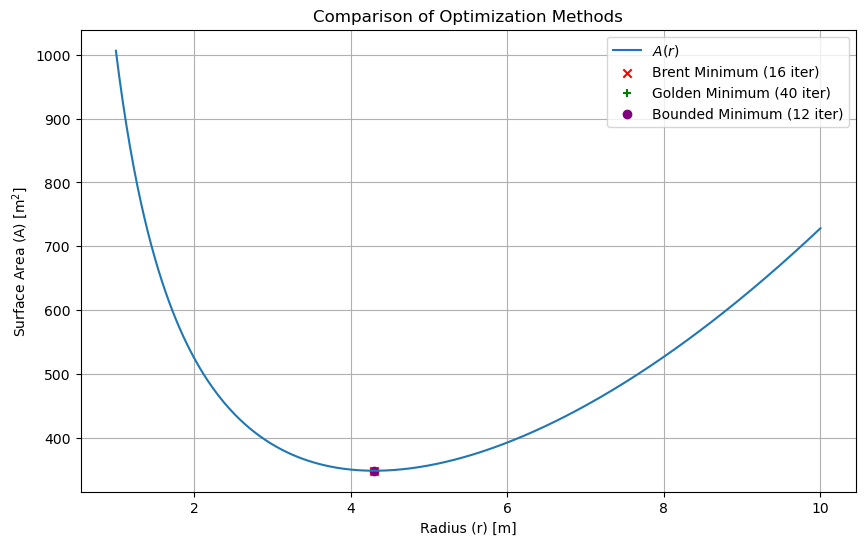

In [8]:
# Visualization
plt.figure(figsize=(10, 6))
plt.plot(r_vals, A_vals, label=r'$A(r)$')
plt.scatter(  brent_result.x,   brent_result.fun, color='red',    marker='x', label=f"Brent Minimum ({    brent_result.nit} iter)")
plt.scatter( golden_result.x,  golden_result.fun, color='green',  marker='+', label=f"Golden Minimum ({  golden_result.nit} iter)")
plt.scatter(bounded_result.x, bounded_result.fun, color='purple', marker='o', label=f"Bounded Minimum ({bounded_result.nit} iter)")

plt.xlabel("Radius (r) [m]")
plt.ylabel("Surface Area (A) [m$^2$]")
plt.title("Comparison of Optimization Methods")
plt.legend()
plt.grid(True)
plt.show()

As you can see, all methods converge to the same solution. The key difference lies in performance (`nit`, `nfev`). Brent's method is generally the most efficient, which is why it's the default. The `bounded` method is indispensable when your problem has hard constraints.


-----

## 3\. Utility Functions for Deeper Insight

SciPy provides several functions that help us understand and control the optimization process.

### 3.1. `show_options()`

Before even running an optimization, you might want to know what parameters you can tune for a specific solver. `show_options` does exactly that.

In [9]:
print("--- Options for minimize_scalar ---")
show_options('minimize_scalar')

--- Options for minimize_scalar ---


brent
=====

Options
-------
maxiter : int
    Maximum number of iterations to perform.
xtol : float
    Relative error in solution `xopt` acceptable for convergence.
disp: int, optional
    If non-zero, print messages.
        0 : no message printing.
        1 : non-convergence notification messages only.
        2 : print a message on convergence too.
        3 : print iteration results.
Notes
-----
Uses inverse parabolic interpolation when possible to speed up
convergence of golden section method.

bounded

Options
-------
maxiter : int
    Maximum number of iterations to perform.
disp: int, optional
    If non-zero, print messages.
        0 : no message printing.
        1 : non-convergence notification messages only.
        2 : print a message on convergence too.
        3 : print iteration results.
xatol : float
    Absolute error in solution `xopt` acceptable for convergence.

golden

Options
-------
xtol : float
    Relative error in sol

In [10]:
print("\n--- Options for the 'brent' method ---")
show_options('minimize_scalar', method='brent')


--- Options for the 'brent' method ---
Options
-------
maxiter : int
    Maximum number of iterations to perform.
xtol : float
    Relative error in solution `xopt` acceptable for convergence.
disp: int, optional
    If non-zero, print messages.
        0 : no message printing.
        1 : non-convergence notification messages only.
        2 : print a message on convergence too.
        3 : print iteration results.
Notes
-----
Uses inverse parabolic interpolation when possible to speed up
convergence of golden section method.


This shows us important options like `xtol` (the tolerance for convergence) and `maxiter` (the maximum number of iterations).

### 3.2. `OptimizeResult` Object

As we've seen, the output of `minimize_scalar` is not just a number, but a rich `OptimizeResult` object. Let's inspect its attributes more closely.

In [11]:
# Let's look at the Brent result again
print(brent_result)

 message: 
          Optimization terminated successfully;
          The returned value satisfies the termination criteria
          (using xtol = 1.48e-08 )
 success: True
     fun: 348.734205452888
       x: 4.301270133158224
     nit: 16
    nfev: 19


In [12]:
# Let's see the keys of the class OptimizeResult (for this particular problem)
print(brent_result.keys())

dict_keys(['fun', 'x', 'nit', 'nfev', 'success', 'message'])


In [13]:
# Accessing individual attributes
print(f"Was the optimization successful? {brent_result.success}")
print(f"Why did it terminate?            {brent_result.message}")
print(f"Optimal point (x):               {brent_result.x}      ")
print(f"Function value at x:             {brent_result.fun}    ")
print(f"Number of iterations:            {brent_result.nit}    ")
print(f"Number of function evaluations:  {brent_result.nfev}   ")

Was the optimization successful? True
Why did it terminate?            
Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol = 1.48e-08 )
Optimal point (x):               4.301270133158224      
Function value at x:             348.734205452888    
Number of iterations:            16    
Number of function evaluations:  19   


This object is your primary tool for diagnosing the performance and outcome of the optimization. Always check `success` and `message`\!

### 3.3. What happens when it is not possible to optimize?

What happens when things don't go perfectly? For instance, if we exceed the maximum number of iterations.

In [14]:
low_iter_result = minimize_scalar(
        surface_area,
        bracket=(1, 10),
        method='golden',       # Slower method, more likely to hit the limit
        options={'maxiter': 5,
                 'disp'   : True}
    )

print("Notice that execution continues...\n")
print("\nResult with low maxiter:")
print(low_iter_result)

print("\n\nAnd finally it issues a warning:")

Notice that execution continues...


Result with low maxiter:
 message: 
          Maximum number of iterations exceeded
 success: False
     fun: 349.07783440598575
       x: 4.437694115157881
     nit: 5
    nfev: 10


And finally it issues a warning:


/home/daalvarez/anaconda3/lib/python3.12/site-packages/scipy/optimize/_optimize.py:3060: OptimizeWarning: 
Maximum number of iterations exceeded
  res = solver(fun, bracket, args, **options)


Notice that `success` is `False`, the message tells us exactly why it failed, and a `OptimizeWarning` was issued. We can catch this warning to handle potential issues gracefully:

In [15]:
import warnings
from scipy.optimize import OptimizeWarning

# Let's force a warning by setting maxiter to a very low number
with warnings.catch_warnings(record=True) as w:
    warnings.simplefilter("always") # We want to see all warnings

    low_iter_result = minimize_scalar(
        surface_area,
        bracket=(1, 10),
        method='golden', # Slower method, more likely to hit the limit
        options={'maxiter': 5,
                 'disp'  :  True}
    )

    # Check if a warning was caught
    if w and issubclass(w[-1].category, OptimizeWarning):
        print("Caught an OptimizeWarning!")
        print(w[-1].message)

print("\nResult with low maxiter:")
print(low_iter_result)

Caught an OptimizeWarning!

Maximum number of iterations exceeded

Result with low maxiter:
 message: 
          Maximum number of iterations exceeded
 success: False
     fun: 349.07783440598575
       x: 4.437694115157881
     nit: 5
    nfev: 10


---

## 4\. Finding a Bracket: The `bracket` Function

Brent's and Golden-Section methods require a "bracket" to guarantee success. How do we find one automatically? The `bracket` function helps with this. Given a function and two starting points `xa` and `xb`, it moves along a direction (from `xa` to `xb`) with geometrically increasing steps until it finds three points $(a, b, c)$ such that $f(b) < f(a)$ and $f(b) < f(c)$.

In [16]:
# Let's try to bracket our function starting from a small radius
# Let xa=1.0 and xb=1.1 (so we are searching in the increasing r direction)
xa, xb, xc, fa, fb, fc, func_calls = bracket(surface_area, xa=1.0, xb=1.1)

print(f"Bracketing successful!")
print(f"Number of function calls: {func_calls}")
print(f"Point a: xa = {xa:.4f}, f(a) = {fa:.4f}")
print(f"Point b: xb = {xb:.4f}, f(b) = {fb:.4f}")
print(f"Point c: xc = {xc:.4f}, f(c) = {fc:.4f}")


Bracketing successful!
Number of function calls: 10
Point a: xa = 3.5099, f(a) = 362.3119
Point b: xb = 4.2328, f(b) = 348.8236
Point c: xc = 4.4784, f(c) = 349.3102


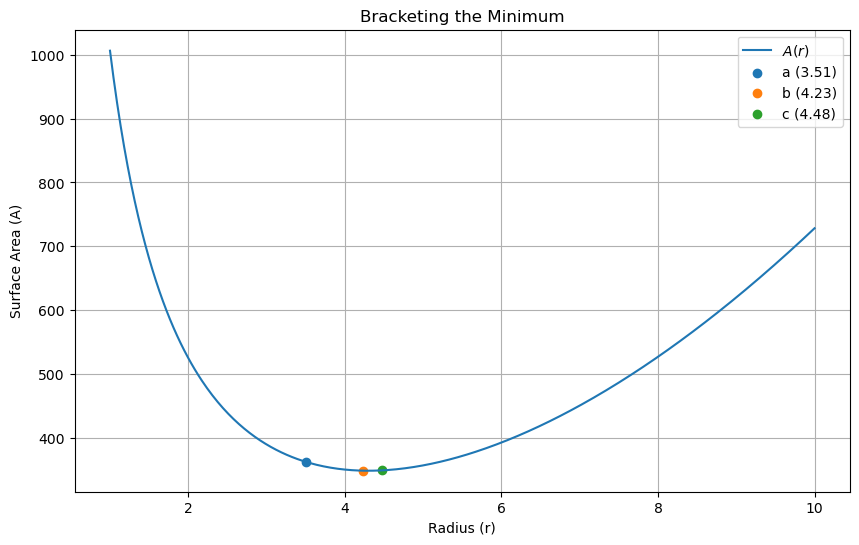

In [17]:
# Visualize the bracket
plt.figure(figsize=(10, 6))
plt.plot(r_vals, A_vals, label=r'$A(r)$')
plt.scatter(xa, fa, label=f'a ({xa:.2f})')
plt.scatter(xb, fb, label=f'b ({xb:.2f})')
plt.scatter(xc, fc, label=f'c ({xc:.2f})')
plt.title("Bracketing the Minimum")
plt.xlabel("Radius (r)")
plt.ylabel("Surface Area (A)")
plt.legend()
plt.grid(True)
plt.show()

The `bracket` function successfully found a valid triplet of points that contains the minimum, which can now be passed directly to `minimize_scalar`.

**Note on `find_minimum` and `bracket_minimum`:** In modern SciPy, `minimize_scalar` has superseded most older, more specific functions. You might see references to `fminbound` (which is what `method='bounded'` calls) or `brent` (the function, not the method string) in older code. Functions like `find_minimum` or `bracket_minimum` are not part of the public API of `scipy.optimize` and should not be used. The canonical way is to use `minimize_scalar` with the appropriate method and `bracket` to find an initial search range if needed.

## Conclusion

Today we have explored the core of univariate optimization in SciPy.

  * We compared **Brent's method**, the **Golden-Section search**, and the **Bounded method**, concluding that Brent's method offers a great balance of speed and reliability, while the Bounded method is essential for constrained problems.
  * We learned how to interpret the `OptimizeResult` object to understand the outcome of our optimization.
  * Finally, we used the `bracket` function to automatically find a valid search interval for our optimization algorithms.

These tools are fundamental for solving a wide array of optimization problems in engineering. Mastering them will allow you to find optimal solutions efficiently and reliably.